In [1]:
import scipy.special as sp
import math as ma
import numpy as np
import scipy.stats as st
import numba as nb
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
import bayessplicedmodels as bsm
from joblib import Parallel, delayed

# Log logistic distribution

$X\sim\text{Pareto}(\alpha, \sigma)$ with pdf

$$
f(x) = \frac{\beta\sigma^\beta x^{\beta-1}}{(\sigma^\beta +x^\beta)^{2}}
$$

In [2]:
class loss_model:
    def __init__(self,name, parm_names):
        self.name = name
        self.parm_names = parm_names
        self.d= len(parm_names)
    
    def set_logp(self, X):
        if self.name == "Log-Logistic":
            def logp(parms):
                β, σ = parms
                if np.all(parms > 0):
                    return(len(X)*( np.log(β) + β * np.log(σ)) + (β - 1) * np.sum(np.log(X)) -
                           2 * np.sum(np.log(σ**β + X**β)))
                else:
                    return(-np.inf)
        self.logp = nb.jit(nopython = True)(logp)
    
    def set_logps(self):
        if self.name == "Log-Logistic":
            def logp_body(X, parms,  γ):
                β, σ = parms
                F1 = 1 / ((σ / γ)**β + 1)
                if np.all(parms) > 0 and F1 > 0:
                    return(len(X)*( np.log(β) + β * np.log(σ)) + (β - 1) * np.sum(np.log(X)) -
                           2 * np.sum(np.log(σ**β + X**β)) - len(X) * np.log(F1))
                else:
                    return(-np.inf)
            
            def logp_tail(X, parms,  γ):
                β, σ = parms
                F1 = 1 / ((σ / γ)**β + 1)
                if np.all(parms) > 0 and F1 < 1:
                    
                    return(len(X)*( np.log(β) + β * np.log(σ)) + (β - 1) * np.sum(np.log(X)) -
                           2 * np.sum(np.log(σ**β + X**β)) - len(X) * np.log(1 - F1))
                else:
                    return(-np.inf)
            
            self.logp_body = nb.jit(nopython = True)(logp_body)
            self.logp_tail = nb.jit(nopython = True)(logp_tail)
    
    def set_logd(self, parms):
        if self.name == "Log-Logistic":
            def logd(x):
                β, σ = parms[:,0], parms[:,1]
                res = np.zeros(len(β))
                s = np.logical_and(β > 0, σ > 0)
                res[np.where(s)] = (np.log(β[s]) + β[s] * np.log(σ[s])) + (β[s] - 1) * np.log(x) - \
                           2 * np.log(σ[s]**β[s] + x**β[s])
                res[np.where(np.invert(s))] = -np.inf
                return(res)
        self.logd = logd
    
    def set_logds(self):
        if self.name == "Log-Logistic":
            
            def logd_body(x, parms,  γ):
                β, σ = parms[:,0], parms[:,1]
                res = np.zeros(len(β))
                s = np.logical_and(np.logical_and(β > 0, σ > 0), x < γ)
                res[np.where(s)] = (np.log(β[s]) + β[s] * np.log(σ[s])) + (β[s] - 1) * np.log(x) - \
                           2 * np.log(σ[s]**β[s] + x**β[s]) - np.log(1 / (1 + (γ[s] / σ[s])**(-β[s])))
                res[np.where(np.invert(s))] = -np.inf
                return(res)
            
            def logd_tail(x, parms,  γ):
                β, σ = parms[:,0], parms[:,1]
                res = np.zeros(len(β))
                s = np.logical_and(np.logical_and(β > 0, σ > 0), x >= γ)
                res[np.where(s)] = (np.log(β[s]) + β[s] * np.log(σ[s])) + (β[s] - 1) * np.log(x) - \
                           2 * np.log(σ[s]**β[s] + x**β[s]) - np.log(1 - 1 / (1 + (γ[s] / σ[s])**(-β[s])))
                res[np.where(np.invert(s))] = -np.inf
                return(res)
            
            self.logd_body = logd_body
            self.logd_tail = logd_tail
    
    def set_cdf(self):
        if self.name == "Log-Logistic":
            def cdf(parms, x):
                β, σ = parms
                return(1 / ((σ/x)**β + 1))
        self.cdf = nb.jit(nopython = True)(cdf)
    
    def set_pdf(self):
        if self.name == "Log-Logistic":
            def pdf(parms, x):
                β, σ = parms
                return(β * σ**β * x**(β - 1) / (σ**β + x**β)**2)
        self.pdf = nb.jit(nopython = True)(pdf)
                
        
    def set_ppf(self):
        if self.name == "Log-Logistic":
            def ppf(parms, y):
                β, σ = parms
                return( σ * (y/(1-y))**(1/β))
        self.ppf = ppf
        
    def sample(self, parms, n):
        if self.name == "Log-Logistic":
            β, σ = parms
            return(st.fisk(β).rvs(size = n) * σ)

In [8]:
log_logistic_dist = loss_model("Log-Logistic", ["β", "σ"])
print(log_logistic_dist.name, log_logistic_dist.parm_names, log_logistic_dist.d)
parms = np.array([3, 1/2])
β, σ = parms
x, y = 2, 0.5
log_logistic_dist.set_cdf(), log_logistic_dist.set_pdf(), log_logistic_dist.set_ppf()
log_logistic_dist.cdf(parms, x) - st.fisk(β).cdf(x / σ),\
log_logistic_dist.ppf(parms, y)-  st.fisk(β).ppf(y) * σ,\
log_logistic_dist.pdf(parms, x)-  st.fisk(β).pdf(x / σ) / σ 

Log-Logistic ['β', 'σ'] 2


(0.0, 0.0, 0.0)

In [9]:
X, γ = st.fisk(β).rvs(size = 100) * σ, 2
log_logistic_dist.set_logps(), log_logistic_dist.set_logp(X)
print(log_logistic_dist.logp(parms) - np.sum(np.log(st.fisk(β).pdf(X / σ) / σ)))
print(log_logistic_dist.logp_body(X, parms, γ) -  np.sum(np.log(st.fisk(β).pdf(X / σ) / σ / st.fisk(β).cdf(γ / σ))))
print(log_logistic_dist.logp_tail(X, parms, γ)-  np.sum(np.log(st.fisk(β).pdf(X / σ) / σ / (1 - st.fisk(β).cdf(γ / σ)))))

-8.526512829121202e-14
-8.526512829121202e-14
-1.7053025658242404e-13


In [10]:
X = st.fisk(β).rvs(size = 10) * σ
β_prior, σ_prior, γ_prior= bsm.prior_model('gamma','β', 1, 1), bsm.prior_model('gamma','σ', 1, 1), bsm.prior_model('gamma','σ', 1, 1)
prior_gamma_model = bsm.independent_priors([β_prior, σ_prior, γ_prior])
particle_cloud = prior_gamma_model.sample(20)
log_logistic_dist.set_logds(), log_logistic_dist.set_logd(particle_cloud.values)
β_vec, σ_vec, γ_vec = particle_cloud.values[:,0], particle_cloud.values[:,1],particle_cloud.values[:,2]
print(np.array([np.log(st.fisk(β_vec[i]).pdf(X[0] / σ_vec[i]) / σ_vec[i]) for i in range(len(γ_vec))] - 
               log_logistic_dist.logd(X[0])))
print(log_logistic_dist.logd_body(X[0], particle_cloud.values, particle_cloud.values[:,-1]) -
      np.array([np.sum(np.log(st.fisk(β_vec[i]).pdf(X[0] / σ_vec[i]) / σ_vec[i] / st.fisk(β_vec[i]).cdf(γ_vec[i] / σ_vec[i]))) 
                for i in range(len(γ_vec)) ]) )
print(log_logistic_dist.logd_tail(X[0], particle_cloud.values, particle_cloud.values[:,-1]) - 
      np.array([np.sum(np.log(st.fisk(β_vec[i]).pdf(X[0] / σ_vec[i]) / σ_vec[i] / (1-st.fisk(β_vec[i]).cdf(γ_vec[i] / σ_vec[i])))) 
                for i in range(len(γ_vec)) ]) )

[ 0.00000000e+00  2.22044605e-16  2.22044605e-16 -4.44089210e-16
  2.22044605e-16  0.00000000e+00  2.22044605e-16 -8.88178420e-16
 -2.22044605e-16  2.22044605e-16 -4.44089210e-16  0.00000000e+00
  0.00000000e+00  2.35922393e-16  8.88178420e-16  1.11022302e-16
  0.00000000e+00  1.11022302e-16 -2.22044605e-16  2.22044605e-16]
[ 0.00000000e+00 -2.22044605e-16            -inf  4.44089210e-16
            -inf            -inf            -inf  8.88178420e-16
  2.35922393e-16 -2.22044605e-16  5.55111512e-16            -inf
            -inf -1.80411242e-16            -inf            -inf
            -inf  0.00000000e+00            -inf            -inf]
[           -inf            -inf  0.00000000e+00            -inf
 -3.33066907e-16  0.00000000e+00  0.00000000e+00            -inf
            -inf            -inf            -inf -1.11022302e-16
  0.00000000e+00            -inf  0.00000000e+00 -1.11022302e-16
  0.00000000e+00            -inf  2.22044605e-16 -4.44089210e-16]


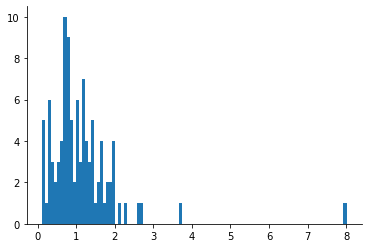

In [11]:
parms_true = np.array([3, 1])
f = loss_model("Log-Logistic", ["β", "σ"])
X= f.sample(parms_true, 100)
plt.hist(X,bins=100)
sns.despine()
β_prior, σ_prior = bsm.prior_model('gamma','β', 1, 1), bsm.prior_model('gamma','σ', 1, 1)
prior_single_model = bsm.independent_priors([β_prior, σ_prior])

In [12]:
popSize, ρ, c, n_step_max, err, paralell, n_proc, verbose = 2000, 1/2, 0.99, 25, 1e-6, False, 4, True
%time trace, log_marg, DIC, WAIC = bsm.smc_likelihood_annealing(X, f, popSize, prior_single_model, ρ, c,n_step_max, err, paralell, 4, verbose)

Sample generation 0 from the gamma-gamma prior distribution
Generation: 1 ;temperature: 0.015532493591308594 ;ESS: 1000 ;steps:4 ;particle moved: 98.45%
Generation: 2 ;temperature: 0.05026336235414419 ;ESS: 999 ;steps:4 ;particle moved: 99.05000000000001%
Generation: 3 ;temperature: 0.14126214182083935 ;ESS: 999 ;steps:4 ;particle moved: 99.65%
Generation: 4 ;temperature: 0.41863184916851554 ;ESS: 999 ;steps:4 ;particle moved: 99.7%
Generation: 5 ;temperature: 1.0 ;ESS: 1273 ;steps:4 ;particle moved: 99.85000000000001%
Wall time: 5.26 s


-99.51769964979772 182.53987405279423 191.04958290753288


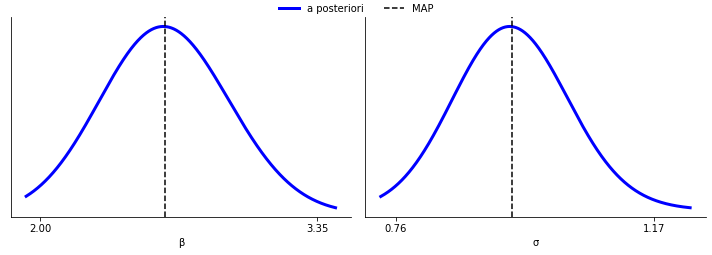

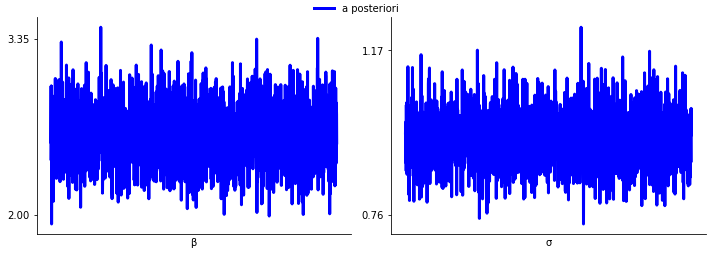

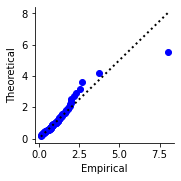

In [13]:
print(log_marg, DIC, WAIC)
bsm.posterior_plots(f, trace)
bsm.trace_plots(f, trace)
f.set_ppf()
bsm.qq_plot(X, f, trace.mean().values)

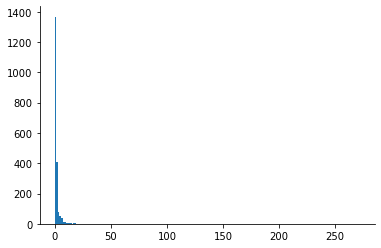

In [21]:
parms_true = np.array([3, 1, 2, 2, 3, 0.9])
f1, f2 =  loss_model("Log-Logistic", ["β1", "σ1"]), loss_model("Log-Logistic", ["β2", "σ2"])
f = bsm.spliced_loss_model(f1 , f2, "disjoint") 
X= f.sample(parms_true, 2000) 
β1_prior, σ1_prior = bsm.prior_model('gamma','β1', 1, 1), bsm.prior_model('gamma','σ1', 1, 1)
β2_prior, σ2_prior = bsm.prior_model('gamma','β2',1, 1), bsm.prior_model('gamma','σ2', 1, 0.11)
γ_prior, p_prior =  bsm.prior_model('gamma','γ',1, 1), bsm.prior_model('beta', 'p', 2, 2)
prior_spliced_model = bsm.independent_priors([β1_prior, σ1_prior,β2_prior, σ2_prior, γ_prior, p_prior])
plt.hist(X,bins=200)
sns.despine()

In [22]:
popSize, ρ, c, n_step_max, err, paralell, n_proc, verbose = 2000, 1/2, 0.99, 25, 1e-6, False, 4, True
%time trace, log_marg, DIC, WAIC = bsm.smc_likelihood_annealing(X, f, popSize, prior_spliced_model, ρ, c,n_step_max, err, paralell, 4, verbose)

Sample generation 0 from the gamma-gamma-gamma-gamma-gamma-beta prior distribution
Generation: 1 ;temperature: 0.0005979537963867188 ;ESS: 1000 ;steps:3 ;particle moved: 100.0%
Generation: 2 ;temperature: 0.0015503895970141457 ;ESS: 1000 ;steps:3 ;particle moved: 100.0%
Generation: 3 ;temperature: 0.0032304140602578517 ;ESS: 1000 ;steps:3 ;particle moved: 100.0%
Generation: 4 ;temperature: 0.00631247160767785 ;ESS: 999 ;steps:3 ;particle moved: 99.9%
Generation: 5 ;temperature: 0.011897624343056542 ;ESS: 999 ;steps:3 ;particle moved: 99.95%
Generation: 6 ;temperature: 0.023064129147125648 ;ESS: 1000 ;steps:3 ;particle moved: 99.9%
Generation: 7 ;temperature: 0.04475982839433276 ;ESS: 1000 ;steps:3 ;particle moved: 99.7%
Generation: 8 ;temperature: 0.08237659399061469 ;ESS: 999 ;steps:3 ;particle moved: 99.7%
Generation: 9 ;temperature: 0.14317557178953916 ;ESS: 999 ;steps:3 ;particle moved: 99.4%
Generation: 10 ;temperature: 0.2342489978026065 ;ESS: 1000 ;steps:3 ;particle moved: 99.65

-1804.7186057943145 3564.6359546555946 3583.9674544821764


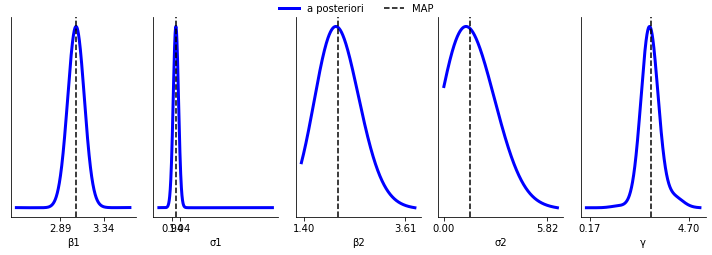

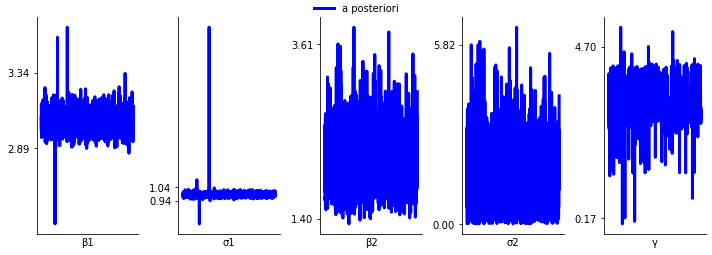

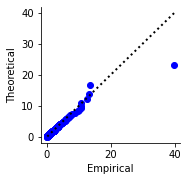

In [20]:
print(log_marg, DIC, WAIC)
f.set_ppf()
bsm.posterior_plots(f, trace)
bsm.trace_plots(f, trace)
bsm.qq_plot(X, f, trace.mean().values)

# On the danish data

In [34]:
# The data
danish = pd.read_csv("Data/danish.csv").x
X = danish.values
# Model for the bulk distribution
body_model_names = ["Log-Logistic"]
# body_model_names = ["Exp", "Gamma"]
body_model_param_names = [["β1", "σ1"]]
# Prior distributions over the parameters of the bulk distribution
body_model_priors= [
                [bsm.prior_model('gamma',body_model_param_names[0][0], 1, 1), bsm.prior_model('gamma',body_model_param_names[0][1], 1, 1)]
]

# Model for the tail of the distribution
# tail_model_names = [ "Log-Logistic", "Lomax", "Burr", "Pareto-Tail", "GPD-Tail", "Inverse-Gamma", "Inverse-Weibull"]
tail_model_names = ["Inverse-Gamma", "Inverse-Weibull", "Burr"]

tail_model_param_names = [ ["β2", "σ2"], ["α2", "σ2"], ["α2", "β2", "σ2"], ["α2"], ["ξ2","σ2"], ["r2", "m2"], ["k2", "β2"]]

# Prior distributions over the parameters of the bulk distribution
tail_model_priors= [
                [bsm.prior_model('gamma',tail_model_param_names[0][0], 1, 1), bsm.prior_model('gamma',tail_model_param_names[0][1], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[1][0], 1, 1), bsm.prior_model('gamma',tail_model_param_names[1][1], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[2][0], 1, 1), bsm.prior_model('gamma',tail_model_param_names[2][1], 1, 1), bsm.prior_model('gamma',tail_model_param_names[2][2], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[3][0], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[4][0], 1, 1), bsm.prior_model('gamma',tail_model_param_names[4][1], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[5][0], 1, 1), bsm.prior_model('gamma',tail_model_param_names[5][1], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[6][0], 1, 1), bsm.prior_model('gamma',tail_model_param_names[6][1], 1, 1)]
]
γ_prior, p_prior = bsm.prior_model('uniform', "γ", min(X), max(X)), bsm.prior_model('uniform',"p", 0, 1)

#Splicing model type
splicing_types = ["continuous", "simple","disjoint"]

# Setting the models
fs, f_names, prior_spliced_model = [], [], []
for i in range(len(body_model_names)):
    for j in range(len(tail_model_names)):
        for splicing_type in splicing_types:
            f1, f2 =  bsm.loss_model(body_model_names[i], body_model_param_names[i]), bsm.loss_model(tail_model_names[j], tail_model_param_names[j])
            fs.append(bsm.spliced_loss_model(f1 , f2, splicing_type))
            f_names.append(body_model_names[i] +"-"+ tail_model_names[j]+"-"+splicing_type)
            if splicing_type == "disjoint": 
                prior_spliced_model.append(bsm.independent_priors(body_model_priors[i] + tail_model_priors[j] + [γ_prior, p_prior]))
            else:
                prior_spliced_model.append(bsm.independent_priors(body_model_priors[i] + tail_model_priors[j] + [γ_prior]))  
for f in fs:
    f.set_ppf()
f_spliced_dic = dict(zip(f_names, fs))

In [35]:
popSize, ρ, c, n_step_max, err, paralell, n_proc, verbose = 1000, 1/2, 0.99, 25, 1e-6, False, 4, False
def fit_spliced_models(i):
        print(f_names[i])
        trace, log_marg, DIC, WAIC = bsm.smc_likelihood_annealing(X, fs[i], popSize, prior_spliced_model[i], ρ, c,n_step_max, err, paralell, 4, verbose)
        return([trace, log_marg, DIC, WAIC])
%time res = Parallel(n_jobs=2)(delayed(fit_spliced_models)(i) for i in range(len(f_names)))

Wall time: 2min 50s


In [36]:
fit_spliced_models_dic = dict(zip(f_names, res))
γ_map = np.array([fit_spliced_models_dic[f_names[k]][0]['γ'].mean() for k in range(len(fit_spliced_models_dic))])
spliced_model_df = pd.DataFrame({'model':f_names,
                                 "d": np.array([f.d for f in fs]),
                                 "γ_map": np.array([fit_spliced_models_dic[f_names[k]][0]['γ'].mean() for k in range(len(fit_spliced_models_dic))]),
                                 'log_marg':  np.array([fit_spliced_models_dic[f_names[k]][1] for k in range(len(fit_spliced_models_dic))]), 
                                 "DIC": np.array([fit_spliced_models_dic[f_names[k]][2] for k in range(len(fit_spliced_models_dic))]), 
                                 "WAIC":np.array([fit_spliced_models_dic[f_names[k]][3] for k in range(len(fit_spliced_models_dic))])})
spliced_model_df["posterior_probability"] = np.exp(spliced_model_df["log_marg"] - np.max(spliced_model_df["log_marg"])) / np.sum(np.exp(spliced_model_df["log_marg"] - np.max(spliced_model_df["log_marg"]))) 

spliced_model_df["Wass_dist"] = np.array([bsm.compute_Wasserstein(X, f_spliced_dic[model_name], fit_spliced_models_dic[model_name][0].mean().values, 1) for model_name in spliced_model_df["model"].values])
spliced_model_df.sort_values(by='log_marg', ascending=False)

,model,d,γ_map,log_marg,DIC,WAIC,posterior_probability,Wass_dist
5,Log-Logistic-Inverse-Weibull-disjoint,6,0.824400,-3820.184118,7557.876761,7575.321022,9.133021e-01,710.167359
0,Log-Logistic-Inverse-Gamma-continuous,5,0.824548,-3822.546180,7579.713761,8486.513697,8.605656e-02,1556.013112
7,Log-Logistic-Burr-simple,6,0.824281,-3827.677090,7555.972692,7564.103639,5.086958e-04,673.370432
4,Log-Logistic-Inverse-Weibull-simple,5,0.824455,-3829.022745,7563.270025,7576.741731,1.324487e-04,732.473144
1,Log-Logistic-Inverse-Gamma-simple,5,0.824509,-3835.607336,7582.485210,7597.493602,1.829767e-07,813.812918
3,Log-Logistic-Inverse-Weibull-continuous,5,0.927910,-3851.342644,7622.026781,7644.332145,2.683111e-14,464.752247
6,Log-Logistic-Burr-continuous,6,0.926346,-3855.598248,7621.090649,7642.279440,3.805861e-16,453.489655
2,Log-Logistic-Inverse-Gamma-disjoint,6,1.178381,-3869.048423,7684.370557,7672.889897,5.484236e-22,400.666509
8,Log-Logistic-Burr-disjoint,7,1.216559,-3877.692623,7666.055028,7669.018173,9.660239e-26,408.581020


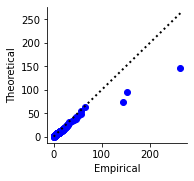

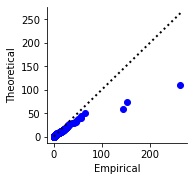

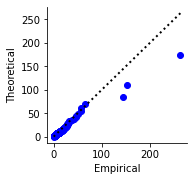

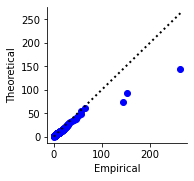

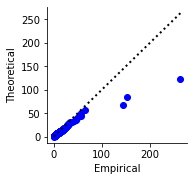

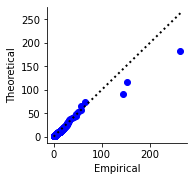

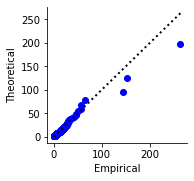

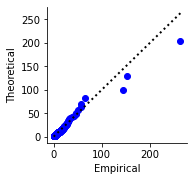

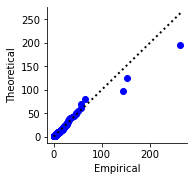

In [38]:
model_names = spliced_model_df.sort_values(by='log_marg', ascending=False)["model"]
for model_name in model_names:
    f, trace = f_spliced_dic[model_name], fit_spliced_models_dic[model_name][0]
    # print(trace.mean().values)
    # bsm.posterior_plots(f, trace)
    # bsm.trace_plots(f, trace)
    
    bsm.qq_plot(X, f, trace.mean().values)